In [1]:
import numpy as np
from pathlib import Path
from importlib import reload

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

In [3]:
# custom libraries
import sys, os
sys.path.append(os.path.abspath('../../spaths'))
import spaths

In [4]:
# underlying OU process coefficients
def drift_ou(t, u, du):
    du[0] = 0.01
    du[1] = u[0] - u[1]

def dispersion_ou(t, u, du):
    du[0] = .01#np.sqrt(0.01)
    du[1] = 1.0#np.sqrt(1.0)

sde_ou = spaths.ItoSDE(drift_ou, dispersion_ou)

In [5]:
# seed setting and solver
seed = 3579
rng = np.random.default_rng(seed)
rng.integers(10**3);  # warm up of RNG

# stochastic solver
em = spaths.EulerMaruyama(rng)

In [6]:
# simulation params
dt = .05
x0, y0 = 3.0, 3.0
tspan = (0.0, 1000)

In [7]:
ens0 = np.array([[x0,y0]]) #spaths.make_ens(x0, y0)
sol_ou = em.solve(sde_ou, ens0, tspan, dt)

In [8]:
sol_ou.p.shape

(1, 20002, 2)

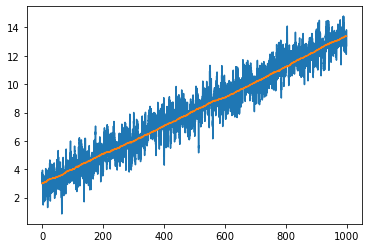

In [9]:
path = sol_ou.p[0]
plt.plot(sol_ou.t, path.T[1])
plt.plot(sol_ou.t, path.T[0]);

In [10]:
data = path[::10]

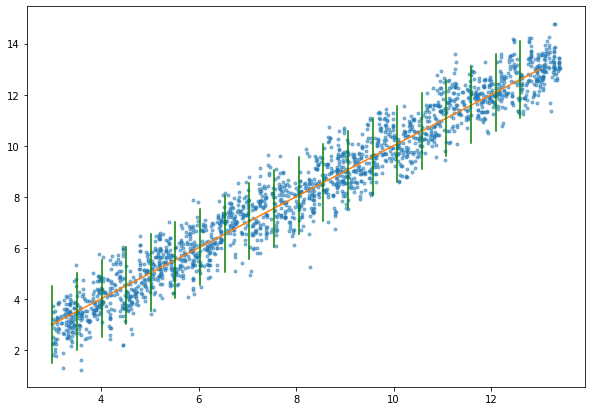

In [75]:
plt.figure(figsize=(10,7))
plt.plot(*data.T, '.', alpha=0.5);
u = np.linspace(3, 13, 100)
plt.plot(u,u);
for u0 in u[::5]:
    u = 50*[u0]
    v = np.linspace(u0-1.5, u0+1.5, 50)
    plt.plot(u, v, color='g');

In [151]:
# transformation
f = lambda r: np.log(1 + r**2)
# g = lambda r: r**3 / (1 + r**2)
g = lambda r: np.sin(.5 * r)
F = lambda u,v: np.array([v, f(v) + g(u - v)])
# fwdF = lambda u: np.asarray([u[1], np.log(1+u[1])+np.sin(.5*(u[0] - u[1]))])

In [152]:
dataF = F(*data.T).T

In [153]:
dataF.shape

(2001, 2)

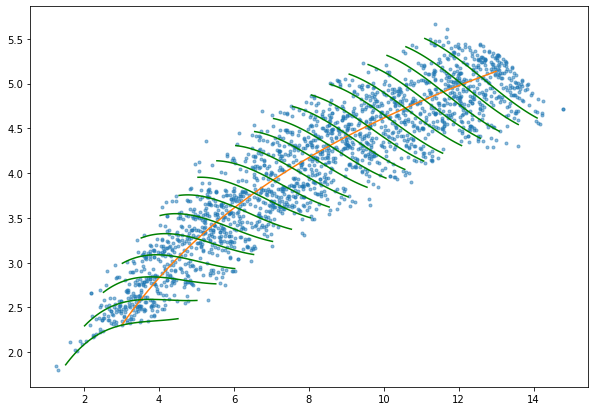

In [154]:
plt.figure(figsize=(10,7))
plt.plot(*dataF.T, '.', alpha=.5);
u = np.linspace(3, 13, 100)
plt.plot(*F(u, u));
for u0 in u[::5]:
    v = np.linspace(u0-1.5, u0+1.5, 50)
    plt.plot(*F(u0, v), color='g')